In [ ]:
!pip install opencage 
!pip install folium
!pip install earthengine-api

import pandas as pd
import numpy as np
from opencage.geocoder import OpenCageGeocode
import time
import folium 
import ee
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv('datafest-data-read-only/Leases.csv')
print(df.columns)


In [11]:
df['full_address'] = df['address'] + ', ' + df['city'] + ', ' + df['state'] + ' ' + df['zip'].astype(str)

In [ ]:
print(df['full_address'])

In [ ]:
key = '795b71df98934b68aa37a1eb12be5fc7'  
geocoder = OpenCageGeocode(key)
latitudes = []
longitudes = []

sample_df = df.head(10)
def geocode_address(address):
    try:
        results = geocoder.geocode(address)
        if results and len(results):
            geometry = results[0]['geometry']
            return pd.Series([geometry['lat'], geometry['lng']])
    except Exception as e:
        print(f"Error geocoding {address}: {e}")
    return pd.Series([None, None])

for address in sample_df['full_address']:
    lat, lon = geocode_address(address)
    latitudes.append(lat)
    longitudes.append(lon)
    time.sleep(2) 

sample_df['latitude'] = latitudes
sample_df['longitude'] = longitudes
print(latitudes)

In [35]:
us_map = folium.Map(location=[37.0902, -95.7129], zoom_start=5)
for lat, lon, address in zip(sample_df['latitude'], sample_df['longitude'], sample_df['full_address']):
    if lat and lon:  # Check if the coordinates exist
        folium.Marker(
            location=[lat, lon],
            popup=address,
            icon=folium.Icon(color='black') 
        ).add_to(us_map)


us_map.save('us_map_with_buildings.html')

In [63]:
df = pd.read_csv('datafest-data-read-only/Leases.csv')

def filter_data(df, year=None, quarter=None, month=None, state=None, city=None, zip_code=None, region=None):
    filtered = df.copy()
    if year is not None:
        if isinstance(year, list):
            filtered = filtered[filtered['year'].isin(year)]
        else:
            filtered = filtered[filtered['year'] == year]

    if quarter is not None:
        if isinstance(quarter, list):
            filtered = filtered[filtered['quarter'].isin(quarter)]
        else:
            filtered = filtered[filtered['quarter'] == quarter]

    if month is not None:
        if isinstance(month, list):
            filtered = filtered[filtered['monthsigned'].isin(month)]
        else:
            filtered = filtered[filtered['monthsigned'] == month]

    if state is not None:
        if isinstance(state, list):
            filtered = filtered[filtered['state'].str.upper().isin([s.upper() for s in state])]
        else:
            filtered = filtered[filtered['state'].str.upper() == state.upper()]

    if city is not None:
        if isinstance(city, list):
            filtered = filtered[filtered['city'].str.lower().isin([c.lower() for c in city])]
        else:
            filtered = filtered[filtered['city'].str.lower() == city.lower()]

    if zip_code is not None:
        if isinstance(zip_code, list):
            filtered = filtered[filtered['zip'].isin(zip_code)]
        else:
            filtered = filtered[filtered['zip'] == int(zip_code)]

    if region is not None:
        if isinstance(region, list):
            filtered = filtered[filtered['region'].str.lower().isin([r.lower() for r in region])]
        else:
            filtered = filtered[filtered['region'].str.lower() == region.lower()]

    return filtered

df_filteredData = filter_data(df,2022, quarter=['Q2'], state = 'FL', city='Tampa')
df_filteredData.to_csv('Data_Before_HurricanIan.csv', index=False)

df_filteredData = filter_data(df,2022, quarter=['Q4'], state = 'FL', city='Tampa')
df_filteredData.to_csv('Data_After_HurricanIan.csv', index=False)   

                           Disaster  T-Statistic       P-Value
0                   Midwest Derecho    -0.667864  5.044640e-01
1                     Hurricane Ida     7.379763  2.113260e-13
2             Los Angeles Wildfires     3.918061  9.089862e-05
3                         Camp Fire     7.310046  3.157815e-13
4                   Hurricane Beryl    -0.384767  7.004527e-01
5                   Hurricane Laura     0.210245  8.334940e-01
6                  Winter Storm Uri     3.992893  6.638307e-05
7                     Hurricane Ian     4.548888  5.533332e-06
8   Western North America Heat Wave     7.898923  3.632435e-15
9                 Western Wildfires    -7.220679  6.347093e-13
10                Hurricane Michael     4.059683  4.984823e-05
11                 Hurricane Helene     8.451318  4.026445e-17


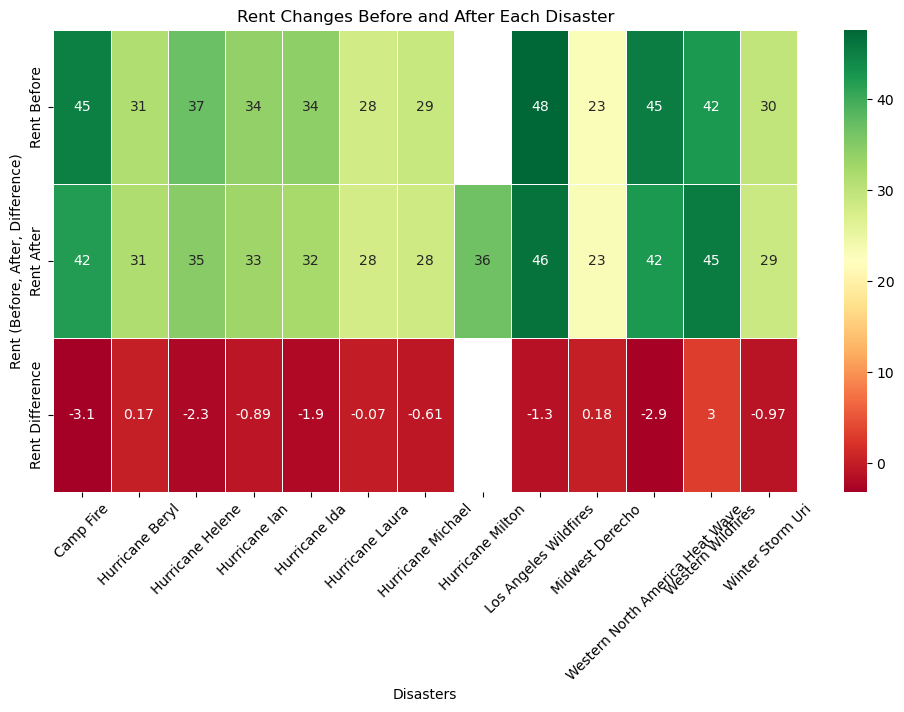

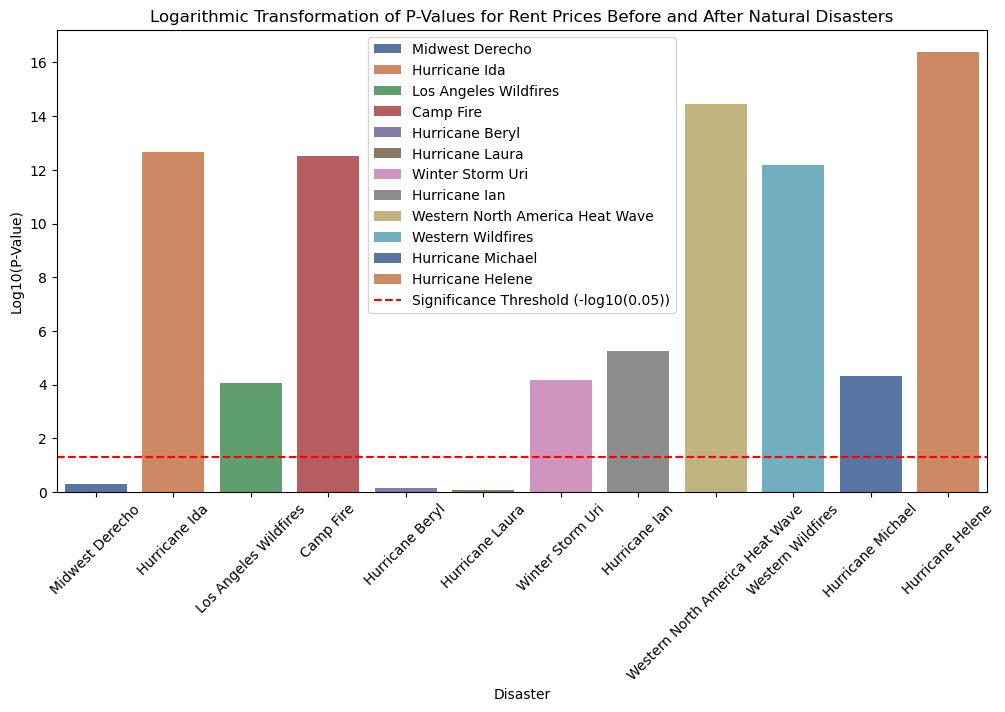

In [185]:
before_df = pd.read_csv('all_disasters_after.csv')
after_df = pd.read_csv('all_disasters_before.csv')

before_df.columns = before_df.columns.str.strip()
after_df.columns = after_df.columns.str.strip()

before_df['total_rent'] = before_df['internal_class_rent'] * before_df['leasedSF']
after_df['total_rent'] = after_df['internal_class_rent'] * after_df['leasedSF']

avg_total_rent_before = before_df.groupby('disaster')['total_rent'].mean()
avg_total_rent_after = after_df.groupby('disaster')['total_rent'].mean()

summary_df = pd.DataFrame({
    'Avg Total Rent Before': avg_total_rent_before,
    'Avg Total Rent After': avg_total_rent_after
})



def perform_t_test(before_df, after_df, disaster_column, rent_column):
    results = []
    
    # Group the data by the disaster type for both before and after DataFrames
    before_groups = before_df.groupby(disaster_column)
    after_groups = after_df.groupby(disaster_column)

    
    
  
    
    common_disasters = before_groups.groups.keys() & after_groups.groups.keys()
    
    for disaster in common_disasters:
        # Get the rents before and after the disaster for this disaster group
        before_rent = before_groups.get_group(disaster)[rent_column]
        after_rent = after_groups.get_group(disaster)[rent_column]
        before_rent_clean = before_rent.dropna()
        after_rent_clean = after_rent.dropna()
        
      
        # Perform the t-test
        t_stat, p_value = stats.ttest_ind(before_rent_clean, after_rent_clean)
        
        # Store the results
        results.append({
            'Disaster': disaster,
            'T-Statistic': t_stat,
            'P-Value': p_value
        })
    
    return pd.DataFrame(results)

# Perform the t-test and get the results
t_test_results = perform_t_test(before_df, after_df, disaster_column='disaster', rent_column='internal_class_rent')


print(t_test_results)

t_test_results.to_csv('t_test_results.csv', index=False)

before_rent_avg = before_df.groupby('disaster')['internal_class_rent'].mean()
after_rent_avg = after_df.groupby('disaster')['internal_class_rent'].mean()

# Create a DataFrame for the heatmap with rent before and after
heatmap_data = pd.DataFrame({
    'Rent Before': before_rent_avg,
    'Rent After': after_rent_avg
})

heatmap_data['Rent Difference'] = heatmap_data['Rent After'] - heatmap_data['Rent Before']

# Create the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data.T, annot=True, cmap="RdYlGn", cbar=True, linewidths=0.5)
plt.title("Rent Changes Before and After Each Disaster")
plt.xlabel("Disasters")
plt.ylabel("Rent (Before, After, Difference)")
plt.xticks(rotation=45)
plt.show()




        


df['log_p_value'] = -np.log10(t_test_results['P-Value'])
df['Disaster Type'] = t_test_results['Disaster']

plt.figure(figsize=(12, 6))

sns.barplot(data=df, x='Disaster Type', y='log_p_value', hue='Disaster Type', palette="deep")

# Adding a threshold for significance
plt.axhline(y=-np.log10(0.05), color='r', linestyle='--', label='Significance Threshold (-log10(0.05))')

plt.xticks(rotation=45)
plt.title('Logarithmic Transformation of P-Values for Rent Prices Before and After Natural Disasters')
plt.xlabel('Disaster')
plt.ylabel('Log10(P-Value)')
plt.legend()
plt.show()








                           Disaster  T-Statistic       P-Value
0                   Midwest Derecho    21.998435  4.519865e-80
1                     Hurricane Ida     6.124092  1.047951e-09
2             Los Angeles Wildfires     5.856976  5.130349e-09
3                         Camp Fire    -0.836753  4.027773e-01
4                   Hurricane Beryl    -1.466188  1.427606e-01
5                   Hurricane Laura    17.469317  1.987691e-64
6                  Winter Storm Uri    11.817922  9.937791e-32
7                     Hurricane Ian    -0.147037  8.831092e-01
8   Western North America Heat Wave    14.909650  6.263001e-49
9                 Western Wildfires    59.555744  0.000000e+00
10                Hurricane Michael    -4.728693  2.318323e-06
11                 Hurricane Helene    -1.812829  6.993577e-02


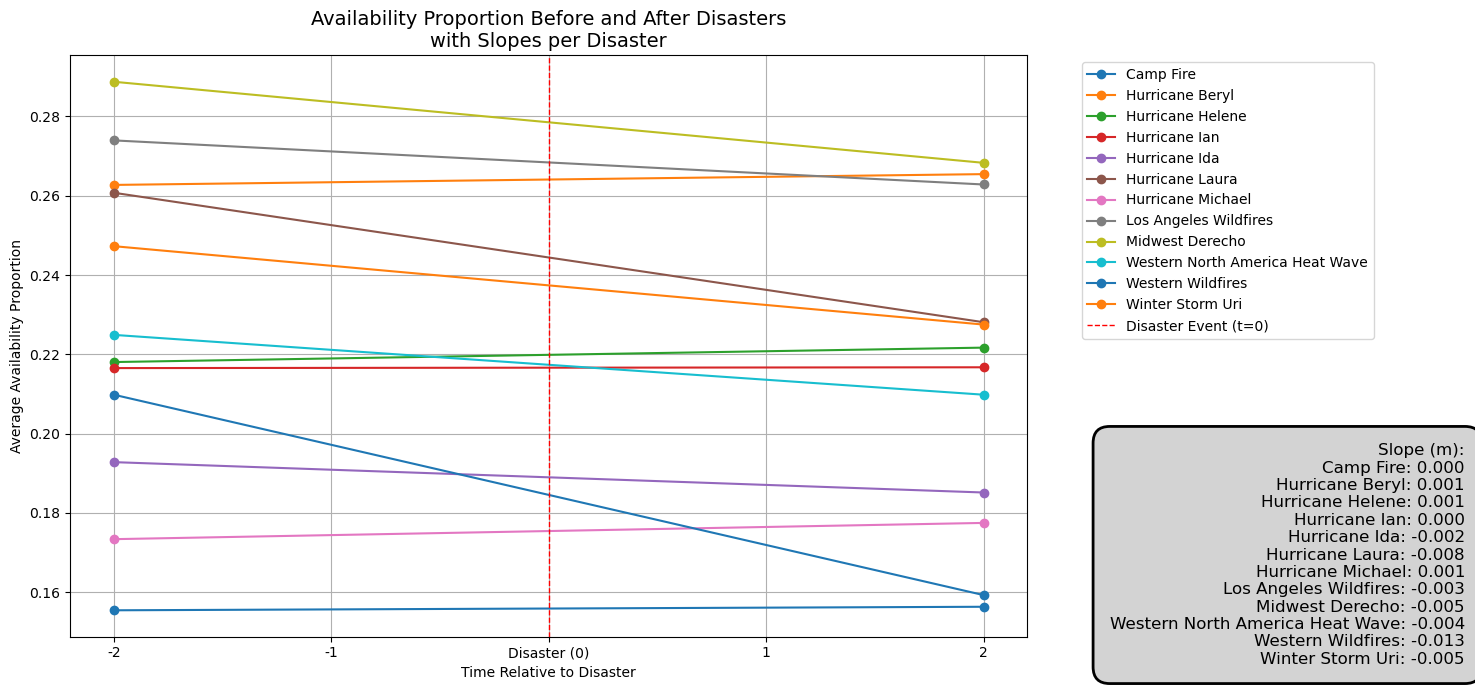

/opt/conda/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning:

divide by zero encountered in log10



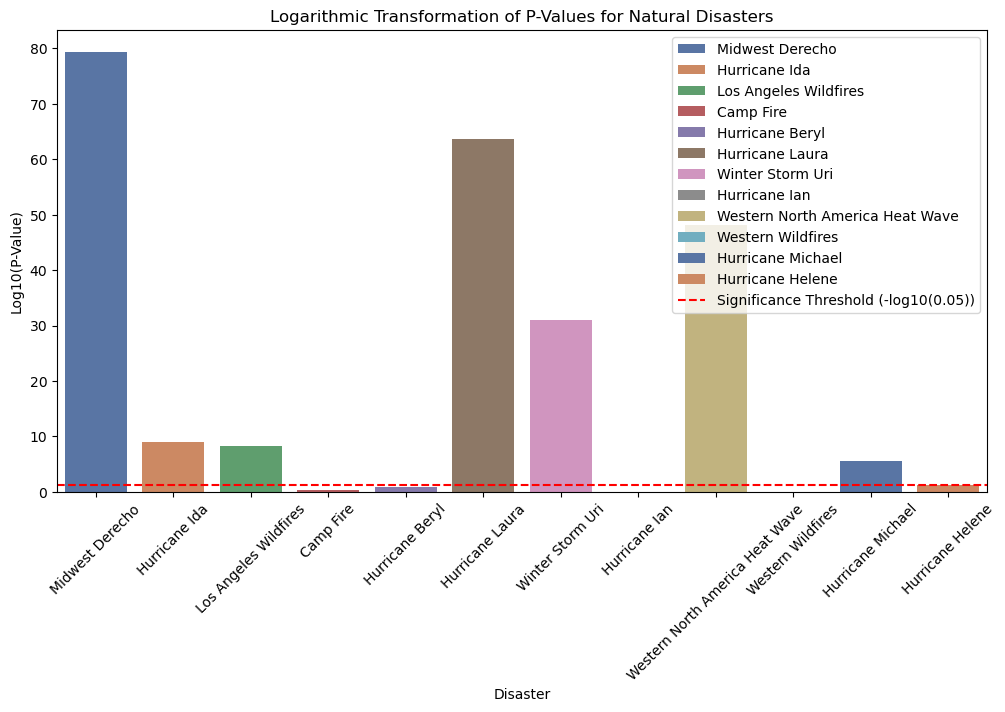

In [183]:
before_df = pd.read_csv('all_disasters_after.csv')
after_df = pd.read_csv('all_disasters_before.csv')

before_df.columns = before_df.columns.str.strip()
after_df.columns = after_df.columns.str.strip()



def perform_t_test(before_df, after_df, disaster_column, rent_column):
    results = []
    
    # Group the data by the disaster type for both before and after DataFrames
    before_groups = before_df.groupby(disaster_column)
    after_groups = after_df.groupby(disaster_column)

    
    
  
    common_disasters = before_groups.groups.keys() & after_groups.groups.keys()
    
    for disaster in common_disasters:
        # Get the rents before and after the disaster for this disaster group
        before_rent = before_groups.get_group(disaster)[rent_column]
        after_rent = after_groups.get_group(disaster)[rent_column]
        before_rent_clean = before_rent.dropna()
        after_rent_clean = after_rent.dropna()
        
      
        # Perform the t-test
        t_stat, p_value = stats.ttest_ind(before_rent_clean, after_rent_clean)
        
        # Store the results
        results.append({
            'Disaster': disaster,
            'T-Statistic': t_stat,
            'P-Value': p_value
        })
    
    return pd.DataFrame(results)


t_test_results = perform_t_test(before_df, after_df, disaster_column='disaster', rent_column='availability_proportion')


print(t_test_results)


t_test_results.to_csv('t_test_results.csv', index=False)


common_disasters = before_avg.index.intersection(after_avg.index)
before_avg = before_avg.loc[common_disasters]
after_avg = after_avg.loc[common_disasters]


plot_df = pd.DataFrame({
    'Disaster': common_disasters,
    'Availability_Before': before_avg.values,
    'Availability_After': after_avg.values
})


plt.figure(figsize=(14, 7))
slope_texts = ["Slope (m):"]

for i, row in plot_df.iterrows():
    x_vals = [-2, 2]
    y_vals = [row['Availability_Before'], row['Availability_After']]

    # Plot line
    plt.plot(x_vals, y_vals, marker='o', label=row['Disaster'])

    # Calculate slope (m)
    m = (y_vals[1] - y_vals[0]) / (x_vals[1] - x_vals[0])
    slope_texts.append(f"{row['Disaster']}: {m:.3f}")


plt.axvline(0, color='red', linestyle='--', linewidth=1, label='Disaster Event (t=0)')


plt.xticks([-2, -1, 0, 1, 2], labels=['-2', '-1', 'Disaster (0)', '1', '2'])
plt.xlabel('Time Relative to Disaster')
plt.ylabel('Average Availability Proportion')
plt.title('Availability Proportion Before and After Disasters\nwith Slopes per Disaster', fontsize=14)
plt.grid(True)


legend = plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


slope_text = "\n".join(slope_texts)
plt.gcf().text(1.05, 0.2, slope_text, fontsize=12, va='center', ha='right', bbox=dict(
    boxstyle="round,pad=1", facecolor="#d3d3d3", edgecolor='black', linewidth=2))

plt.tight_layout()
plt.show()








        


df['log_p_value'] = -np.log10(t_test_results['P-Value'])
df['Disaster Type'] = t_test_results['Disaster']

plt.figure(figsize=(12, 6))

sns.barplot(data=df, x='Disaster Type', y='log_p_value', hue='Disaster Type', palette="deep")

# Adding a threshold for significance
plt.axhline(y=-np.log10(0.05), color='r', linestyle='--', label='Significance Threshold (-log10(0.05))')

plt.xticks(rotation=45)
plt.title('Logarithmic Transformation of P-Values for Natural Disasters')
plt.xlabel('Disaster')
plt.ylabel('Log10(P-Value)')
plt.legend()
plt.show()